In [24]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [25]:
vi = 0.01

Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)

TC = 0.158

kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]

kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]

kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]

kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]

kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]

kc6 = 0.2*TC 
# production of mdm2 [1/min]

kc7 = 0.1*TC 
# degradation of mdm2 [1/min]

kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

In [26]:
def p_change(t, p, m, Mf, Mb, n):
    dpdt = kc1 - kc2*Mf*(p / (kc3 + p))
    return dpdt

def m_change(t, p, m, Mf, Mb, n):
    dmdt = (kc4 * p**2 - kc5 * m)
    return dmdt

def M_free_change(t, p, m, Mf, Mb, n):
    dM_freedt = kc6 * m - kc7 * Mf - kc8*n*Mf
    return dM_freedt

def M_bound_change(t, p, m, Mf, Mb, n):
    dM_bounddt = - kc7*Mb + kc8*n*Mf
    return dM_bounddt

def n_change(t, p, m, Mf, Mb, n):
    dndt = -kc8*n*Mf
    return dndt

def samlet_system(t, y):
    dydt = np.zeros_like(y)
    dydt[0] = p_change(t, *y)
    dydt[1] = m_change(t, *y)
    dydt[2] = M_free_change(t, *y)
    dydt[3] = M_bound_change(t, *y)
    dydt[4] = n_change(t, *y)
    return dydt

In [27]:
t_samlet = (0, 5000)

p0, m0, Mf0, Mb0, n0 = 100, 1, 1, 1, 1

y0 = [p0, m0, Mf0, Mb0, n0]

In [28]:
samlet_løsning = solve_ivp(samlet_system, t_samlet, y0, method='RK45')
print(samlet_løsning)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.698e-02 ...  4.989e+03  5.000e+03]
        y: [[ 1.000e+02  1.001e+02 ...  6.308e+01  6.877e+01]
            [ 1.000e+00  1.253e+00 ...  3.343e+01  3.945e+01]
            ...
            [ 1.000e+00  9.988e-01 ... -7.076e-07 -1.458e-07]
            [ 1.000e+00  9.997e-01 ...  6.556e-07  1.346e-07]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4148
     njev: 0
      nlu: 0


In [44]:
t_int, p_int, m_int, Mf_int, Mb_int, n_int = samlet_løsning["t"], samlet_løsning["y"][0], samlet_løsning["y"][1], samlet_løsning["y"][2], samlet_løsning["y"][3], samlet_løsning["y"][4]

[]

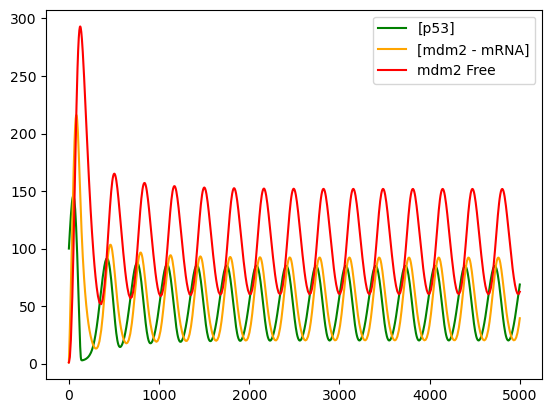

In [30]:
plt.plot(t, p, color="green", label="[p53]")
plt.plot(t, m, color="orange", label="[mdm2 - mRNA]")
plt.plot(t, Mf, color="red", label="mdm2 Free")


plt.legend()
plt.plot()

Hvorfor eksploderer mængden af `Mb`?

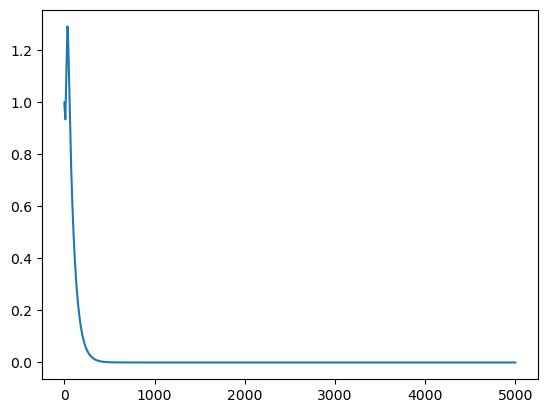

In [31]:
plt.plot(t,Mb)

### Peakfinding med scipy

"For several conditions the interval borders can be specified with arrays matching x in shape which enables dynamic constrains based on the sample position."

In [32]:
# TODO: Figure out how to first run this after transient. 



print(p53_peaks)

NameError: name 'p53_peaks' is not defined

NameError: name 'p53_peaks' is not defined

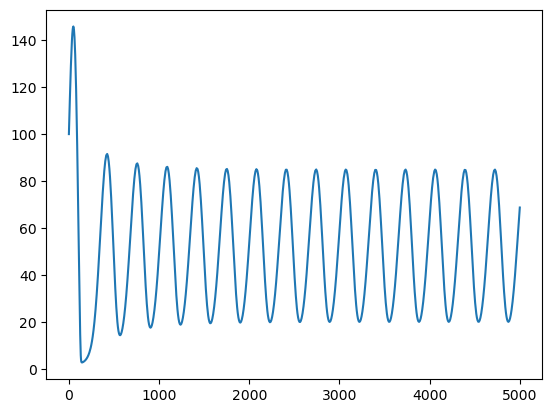

In [33]:
plt.plot(t, p, label="[p53]")
plt.scatter(t[p53_peaks], p[p53_peaks], s=80, c="red", marker="x")
plt.scatter(t[p53_troughs], p[p53_troughs], s=80, c="green", marker="+")

### Period and amplitude

In [34]:
print(len(p53_peaks))

NameError: name 'p53_peaks' is not defined

In [35]:
def find_map(t, y): #mean, amplitude, period
    y_peaks = find_peaks(y)[0]
    y_troughs = find_peaks(-y)[0]

    # Only keep peaks after the 10 first peaks. We assume that the period and amplitude will be approx. stable after this.
    stable_peaks = None
    stable_troughs = None
    if len(y_peaks) > 12 and len(y_peaks) > len(y_troughs):
        stable_peaks = y_peaks[10:-2]
        stable_troughs = y_troughs[10:-1]
    else:
        stable_peaks = y_peaks[10:-1]
        stable_troughs = y_troughs[10:-1]
        
    # Is it true that N is larger when using troughs also? So that the uncertainty is smaller?
    period = np.mean((np.diff(t[stable_peaks]) + np.diff(t[stable_troughs]))/2)
    # TODO: Calculate uncertainty for this!
    
    amplitude = np.mean((y[stable_peaks] - y[stable_troughs])/2)

    mean_value = np.mean(np.concatenate((y[stable_peaks] - amplitude, y[stable_troughs] + amplitude)))

    return period, amplitude, mean_value, stable_peaks, stable_troughs

In [36]:
period, amplitude, mean_value, stable_peaks, stable_troughs = find_map(t, p)

In [37]:
print(period, amplitude, mean_value)

329.1125843870209 32.35464308364189 52.49419813103056


In [60]:
def sim_onoff_nutlin(perioder, T_ext, p0, m0, Mf0, Mb0, A_ext):

    history = {"t":[0.0] ,"p": [p0], "m": [m0], "Mf": [Mf0], "Mb":[Mb0], "n":[0.0]}

    for i in range(perioder):
        
        # Nutlin turned off for one period
        if i % 2 == 0:
            state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], 0
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45')
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].append(t + history["t"][-1])
            history["p"].append(p)
            history["m"].append(m)
            history["Mf"].append(Mf)
            history["Mb"].append(Mb)
            history["n"].append(n)

        # Nutlin turned on for one period
        else:
            state = history["p"][-1], history["m"][-1], history["Mf"][-1], history["Mb"][-1], A_ext
            sys = solve_ivp(samlet_system, (0, T_ext), state, method='RK45')
            t, p, m, Mf, Mb, n = np.array(sys["t"]), sys["y"][0], sys["y"][1], sys["y"][2], sys["y"][3], sys["y"][4]
            history["t"].append(t + history["t"][-1])
            history["p"].append(p)
            history["m"].append(m)
            history["Mf"].append(Mf)
            history["Mb"].append(Mb)
            history["n"].append(n)
    
    return history

In [61]:
nutlin_sim1 = sim_onoff_nutlin(50, period, p_int[-1], m_int[-1], Mf_int[-1], Mb_int[-1], 15)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (5,) + inhomogeneous part.

Text(0.5, 1.0, 'Oscillationer af p53 koncentration med perioden T = 330.5 [min]')

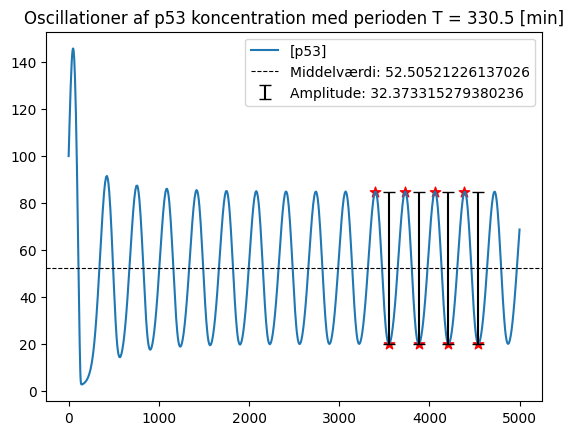

In [238]:
plt.plot(t, p, label="[p53]")
plt.scatter(t[stable_peaks], p[stable_peaks], s=60, c="red", marker='*')
plt.scatter(t[stable_troughs], p[stable_troughs], s=60, c="red", marker='*')

plt.axhline(mean_value, color="black", linestyle="dashed", lw=.8, label=f"Middelværdi: {mean_value}")
plt.errorbar(t[stable_troughs], np.ones(len(t[stable_troughs]))*mean_value, yerr=amplitude, fmt="none", ecolor="black", capsize = 4, label=f"Amplitude: {amplitude}")

plt.legend()

plt.title(f"Oscillationer af p53 koncentration med perioden T = {period:.4} [min]")